In [ ]:
import zipfile
import os

zip_path = "/content/Dataset.zip"
extract_path = "/content/Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")
print("Folders:", os.listdir(extract_path))

✅ Dataset extracted!
Folders: ['Dataset']


In [ ]:
# STEP 2: SPLIT INTO TRAIN, VAL, TEST
import shutil
import random
from pathlib import Path

src_dir = Path("/content/Dataset/Dataset")
categories = ['Benign', 'Malignant']

base_dir = Path("/content/breast_data")
train_dir, val_dir, test_dir = base_dir / "train", base_dir / "val", base_dir / "test"

for split_dir in [train_dir, val_dir, test_dir]:
    for category in categories:
        os.makedirs(split_dir / category, exist_ok=True)

def split_and_copy(category):
    images = list((src_dir / category).glob("*.png"))
    random.shuffle(images)
    total = len(images)
    train_split = int(0.7 * total)
    val_split = int(0.85 * total)

    for i, img_path in enumerate(images):
        if i < train_split:
            dest = train_dir / category / img_path.name
        elif i < val_split:
            dest = val_dir / category / img_path.name
        else:
            dest = test_dir / category / img_path.name
        shutil.copy(img_path, dest)

for category in categories:
    split_and_copy(category)

print("✅ Data split into train, val, and test")


✅ Data split into train, val, and test


In [ ]:
# STEP 3: LOAD DATA WITH IMAGE GENERATORS
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 70 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# STEP 4: CNN MODEL ARCHITECTURE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# STEP 5: TRAIN THE MODEL

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.4863 - loss: 7.8000 - val_accuracy: 0.5000 - val_loss: 0.8207
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.4655 - loss: 10.0805 - val_accuracy: 0.4286 - val_loss: 0.7587
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6385 - loss: 1.0448 - val_accuracy: 0.5000 - val_loss: 0.7608
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5651 - loss: 1.0816 - val_accuracy: 0.4286 - val_loss: 1.0340
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.6996 - loss: 0.9670 - val_accuracy: 0.5714 - val_loss: 1.2925
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.5435 - loss: 0.7990 - val_accuracy: 0.5000 - val_loss: 1.4980
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6411 - loss: 1.1551 - val_accuracy: 0.4286 - val_loss: 2.7072


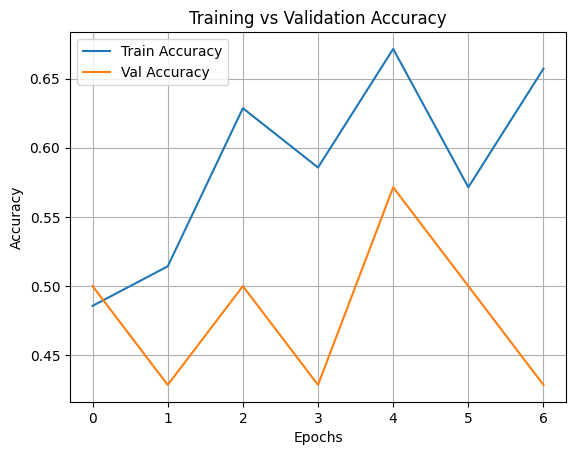

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - accuracy: 0.5000 - loss: 0.6768
✅ Test Accuracy: 50.00%


In [ ]:
# STEP 6: VISUALIZE & EVALUATE
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


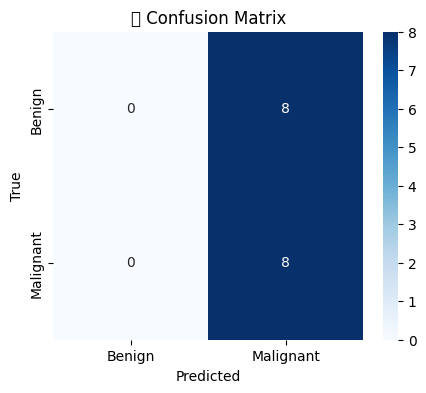

📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00         8
   Malignant       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Step 7: Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("🧠 Confusion Matrix")
plt.show()

print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))
